# Medicare Statistics example:

For an examaple of applying statistics to the real world.

## Business Question
Let's compare two facilities or organizations to see if there is a significant difference in MIPs score

[Data Source (CMS.gov)](https://data.cms.gov/provider-data/dataset/a174-a962)
>This file contains Merit-Based Incentive Payment System (MIPS) Final Scores and performance category scores for clinicians. 

![Image](dd2.png)
![Image](dd1.png)

In [2]:
import pandas as pd # import pandas to read in the data
from scipy.stats import ttest_ind
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Data Cleaning
Todo: 
- Focus in on the final MIPs score
- Handle missing data for organizations & facilities

In [3]:
df = pd.read_csv('ec_score_file.csv')

In [4]:
# Check out the head of the data
df.head()

,NPI,Org_PAC_ID,lst_nm,frst_nm,source,facility_ccn,facility_lbn,Quality_category_score,PI_category_score,IA_category_score,Cost_category_score,final_MIPS_score_without_CPB,final_MIPS_score
0,1003028101,NaN,KATZ,KENNETH,individual,NaN,NaN,NaN,NaN,NaN,NaN,60.0000,60.0000
1,1003028556,NaN,HEIDARI,NEDA,individual,NaN,NaN,94.641,58.0,20.0,NaN,76.9526,82.1725
2,1003220351,NaN,NAUMOVA,YULIA,individual,NaN,NaN,NaN,NaN,NaN,NaN,60.0000,60.0000
3,1003808494,NaN,CHANG,ANDREW,individual,NaN,NaN,NaN,NaN,NaN,NaN,60.0000,60.0000
4,1003813262,NaN,HALAWA,ABDUL,individual,NaN,NaN,30.000,NaN,40.0,NaN,40.5000,47.1600


**Observations**
- There's a significant number of missing data
- There's in NPI (identifies a clinician)
- There are a bunch of scores for specific categories, and a final score
- There are names of clinicians which we will anonymize
- There are organization and facility identifiers, and some are null


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698883 entries, 0 to 698882
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   NPI                            698883 non-null  int64  
 1    Org_PAC_ID                    697134 non-null  float64
 2    lst_nm                        698858 non-null  object 
 3    frst_nm                       698870 non-null  object 
 4    source                        698883 non-null  object 
 5    facility_ccn                  0 non-null       float64
 6    facility_lbn                  0 non-null       float64
 7    Quality_category_score        604815 non-null  float64
 8    PI_category_score             444186 non-null  float64
 9    IA_category_score             625268 non-null  float64
 10   Cost_category_score           0 non-null       float64
 11   final_MIPS_score_without_CPB  698883 non-null  float64
 12   final_MIPS_score             

**Observations**
- There are no facility data so we can't compare facilities

In [6]:
# Create a copy of our data for cleaning
df_clean = df

In [7]:
# clean column names by removing any excess spaces
df_clean = df_clean.rename(columns=lambda x: x.replace(" ", ""))

In [8]:
# Keep only the columns we need
df_clean = df_clean[['NPI', 'Org_PAC_ID', 'source', 'final_MIPS_score']]
df_clean.head()

,NPI,Org_PAC_ID,source,final_MIPS_score
0,1003028101,NaN,individual,60.0000
1,1003028556,NaN,individual,82.1725
2,1003220351,NaN,individual,60.0000
3,1003808494,NaN,individual,60.0000
4,1003813262,NaN,individual,47.1600


In [9]:
# Drop all missing data
df_clean = df_clean.dropna()

In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697134 entries, 1749 to 698882
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   NPI               697134 non-null  int64  
 1   Org_PAC_ID        697134 non-null  float64
 2   source            697134 non-null  object 
 3   final_MIPS_score  697134 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 26.6+ MB


## EDA
- Explore the org_pac_id
- Explore the source
- Explore the MIPs score

In [11]:
df_clean['Org_PAC_ID'].astype('str').value_counts()

3375701568.0    4884
6507778255.0    4300
1355232422.0    3761
8729990239.0    3715
1052223229.0    2972
                ... 
3577794163.0       1
1850576133.0       1
7517395312.0       1
840464137.0        1
9234386038.0       1
Name: Org_PAC_ID, Length: 52292, dtype: int64

**Top Two Organization IDs**
- 3375701568
- 6507778255

In [12]:
df_clean['source'].value_counts()

group            468949
apm              158698
individual        69378
virtual group       109
Name: source, dtype: int64

To go back to the data dictionary these are:

> Method by which the clinician achieved
> scores (“individual”, “group”, “virtual group”,
> or “apm”); if the source is “apm”, this
> indicates that the MIPS APM scoring standard
> was applied for this set of scores


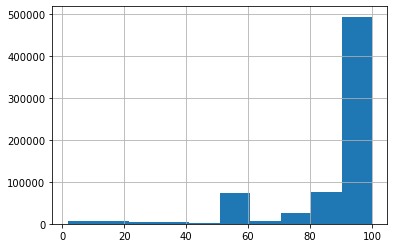

In [13]:
# Explore the MIPS scores
df_clean['final_MIPS_score'].hist();

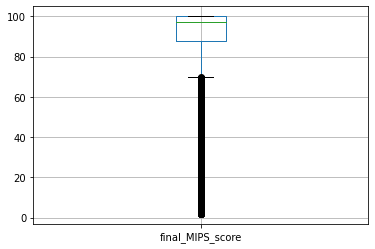

In [14]:
# Explore the MIPS scores
df_clean.boxplot(column='final_MIPS_score');

**Observations**
- I'm noticing lots of low outliers
- The data seems to be fairly non-normally distributed
- The data is skewed left
- The data is leptokurtic

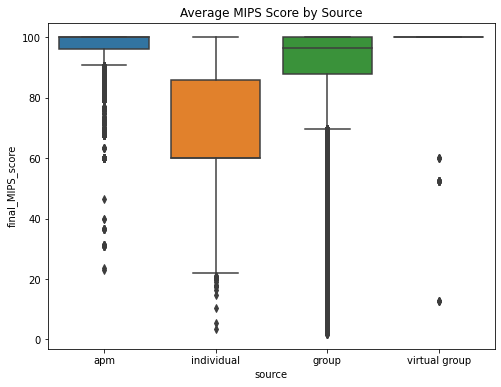

In [15]:
# Average final MIPS score by source
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=df_clean,x='source',y='final_MIPS_score',ax=ax)
ax.set_title('Average MIPS Score by Source');

**Observations**
- The widest range is in the individual section
- There are a significant number of outliers in the group and APM sources

In [16]:
# We're looking for variation so let's explore the individual source
source_filter = df_clean['source']=='individual'

df_clean[source_filter]['Org_PAC_ID'].astype('str').value_counts()

3779471701.0    210
2264344480.0    207
7012047640.0    172
9830082882.0    152
9032111281.0    140
               ... 
4789679697.0      1
1052587276.0      1
7517204555.0      1
6103065545.0      1
8224008891.0      1
Name: Org_PAC_ID, Length: 35044, dtype: int64

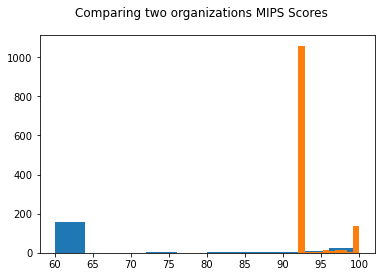

In [17]:
# Identifying the organization IDs
org_1 = 3779471701 #Forefront Dermatology
org_2 = 2264344480 # University Of Cincinnati Physicians Company LLC

org_1_data = df_clean[ df_clean['Org_PAC_ID']==org_1 ]['final_MIPS_score']
org_2_data = df_clean[ df_clean['Org_PAC_ID']==org_2 ]['final_MIPS_score']

fig, ax = plt.subplots()
fig.suptitle('Comparing two organizations MIPS Scores')
ax.hist(org_1_data)
ax.hist(org_2_data);

**Observations**
- They look fairly different
- They're both fairly non-normally distributed

In [21]:
org_1_med = round(np.median(org_1_data),2)
org_2_med = round(np.median(org_2_data),2)
ord_2_1_diff = round(org_2_med - org_1_med,2)

print(f'Org 1 median: {org_1_med}')
print(f'Org 1 median: {org_2_med}')
print(f'Org 2 median is {ord_2_1_diff} higher than Org 1 median')

Org 1 median: 60.0
Org 1 median: 92.01
Org 2 median is 32.01 higher than Org 1 median


## Modeling


Let's now answer the question if these two organizations are significantly different. (one-sided two-sample t-test)

$H_0$: _UoCPC has lower overall MIPS scores than Forefront Derm

$H_1$: _UoCPC has higher overall MIPS scores than Forefront Derm

We'll use an significance level of $\alpha = 0.05$

In python this is a single line

In [19]:
ttest_ind(org_1_data, org_2_data, equal_var = False)

Ttest_indResult(statistic=-23.607082928158665, pvalue=3.858864879417511e-61)

Our p-value is less than $\alpha$ so we can conclude that these two populations are significantly different

*Note: since we're using a two-sided test here and we actually want a 1-sided test we divide p by 2*

# Conclusion
UoCPC has higher overall MIPS scores than Forefront Derm at a confidence level of 95%.

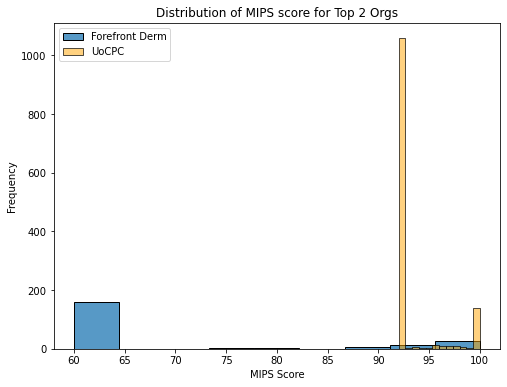

In [20]:
fig, axs = plt.subplots(figsize=(8,6))
sns.histplot(org_1_data, label='Forefront Derm')
sns.histplot(org_2_data, label='UoCPC',color='orange', alpha=.5)

plt.xlabel("MIPS Score")
plt.ylabel("Frequency")
plt.title("Distribution of MIPS score for Top 2 Orgs")
plt.legend();